In [1]:
# test
#a_0 = tf.constant([[1, 2, 1], [3,4,3]],dtype = 'float32')
#w_0 = tf.constant([[5, 6, 20, 19], [7, 8, 40, 60], [7, 8, 93, 95]],dtype = 'float32')

#with tf.Session() as sess:
#    print(tf.matmul(a_0, w_0).eval())
#    print(tf.reduce_mean(tf.matmul(a_0, w_0), 0).eval())
#    print(sess.run(tf.reduce_sum(tf.log(tf.reduce_mean(tf.matmul(a_0, w_0), 0)))))

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)

plt.style.use('ggplot')

In [3]:
def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

    return x


N = 500  # number of data points
K = 3  # number of components
D = 2  # dimensionality of data
ed.set_seed(42)

x_train = build_toy_dataset(N)

In [4]:
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [5]:
T = 200  # number of MCMC samples
qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [6]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

/Users/zhonglingjiang/anaconda3/envs/mlprobprog/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  1/200 [  0%]                                ETA: 112s | Acceptance Rate: nan
Inferred cluster means:
[[-0.19289383 -0.06122107]
 [ 0.39130777  0.4030813 ]
 [-0.43831307 -0.96308833]]
  4/200 [  2%]                                ETA: 31s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.17455232 -0.10522678]
 [ 0.2350442  -0.40428546]
 [-0.82848865 -0.8526497 ]]
  6/200 [  3%]                                ETA: 21s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.07083412 -0.04077583]
 [ 0.17225477  0.18903613]
 [-0.89513266 -0.9184082 ]]
  8/200 [  4%] █                              ETA: 16s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.07529727  0.12312572]
 [ 0.04114929  0.10601661]
 [-0.9491981  -0.93688816]]
 10/200 [  5%] █                              ETA: 13s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.24764317  0.31078687]
 [ 0.15706918  0.21650644]
 [-0.9696233  -0.94467545]]
 12/200 [  6%] █                              ETA: 11s | Acceptance Rat

178/200 [ 89%] ██████████████████████████     ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.94473505  0.98813546]
 [ 0.04457749  0.09596567]
 [-1.0097263  -0.9681047 ]]
180/200 [ 90%] ███████████████████████████    ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.9450188   0.98833966]
 [ 0.03245955  0.09426638]
 [-1.0098699  -0.96788645]]
182/200 [ 91%] ███████████████████████████    ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.9453717   0.98846394]
 [ 0.02375729  0.08380356]
 [-1.010116   -0.9682183 ]]
184/200 [ 92%] ███████████████████████████    ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.9459488   0.98895425]
 [ 0.01448025  0.08911777]
 [-1.0101343  -0.96804976]]
186/200 [ 93%] ███████████████████████████    ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.9464532   0.98911923]
 [ 0.01499475  0.08331109]
 [-1.0100842  -0.96812075]]
188/200 [ 94%] ████████████████████████████   ETA: 0s | Acceptance Rate: 1.

In [7]:
mu_sample = qmu.sample(100) #(sample size, K, D)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))   #(T, sample size, K, D)
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])  

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

In [8]:
clusters = tf.argmax(log_liks, 1).eval()

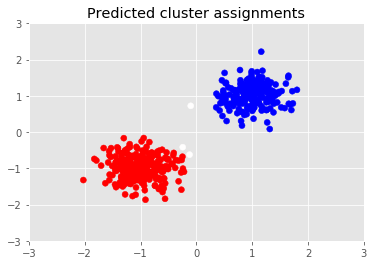

In [9]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [10]:
M = 100
pi_sample = qpi.sample(M) # (100 * K)

In [11]:
pi_sample

<tf.Tensor 'Empirical/sample_1/Reshape_2:0' shape=(300, 3) dtype=float32>

### Posterior Dispersion Index

In [12]:
log_liks2 = x_post.log_prob(x_broadcasted) 

In [13]:
log_liks2 = tf.reduce_sum(log_liks2, 3)

In [14]:
log_liks2

<tf.Tensor 'Sum_1:0' shape=(500, 100, 3) dtype=float32>

In [15]:
pi_samples_tiled = tf.tile(tf.expand_dims(tf.transpose(pi_sample), 0), [N, 1,1]) # [500, 7, 100], [N, K, M]

### PDI definition

In [16]:
p_x_given_theta = tf.matmul(tf.exp(log_liks2), pi_samples_tiled) #[N, ?, ?] in this case is different pi and (mu, sigma) combo
p_x_given_theta = tf.reshape(p_x_given_theta, [N, -1]) # [N, ? * ?]

In [17]:
mean, variance = tf.nn.moments(p_x_given_theta, axes=[1])

In [18]:
pdi = tf.div(variance, mean)

In [19]:
pdi_values = sess.run(pdi)

In [20]:
largest_five_pdis = pdi_values.argsort()[-5:][::-1]
pdi_values[largest_five_pdis]

array([0.26934355, 0.17912969, 0.12939413, 0.12611565, 0.12323079],
      dtype=float32)

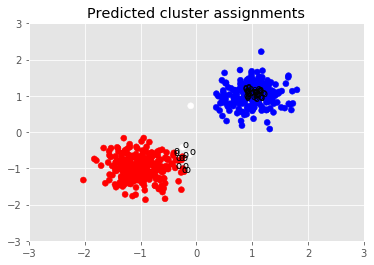

In [21]:
num_top_pdis = 50
largest_pdis = pdi_values.argsort()[-num_top_pdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_pdis): 
    plt.text(x_train[largest_pdis[i]][0],x_train[largest_pdis[i]][1] , "o", fontsize=10)
plt.show()

### WAPDI definition

In [22]:
p_x_given_theta_2 = tf.matmul(tf.exp(log_liks2), pi_samples_tiled)
p_x_given_theta_2 = tf.reshape(tf.log(p_x_given_theta), [N, -1])
mean_2, variance_2 = tf.nn.moments(p_x_given_theta_2, axes=[1])
wapdi = tf.div(variance_2, mean_2)

In [23]:
wapdi_values = sess.run(wapdi)

In [24]:
largest_five_wapdis = wapdi_values.argsort()[-5:][::-1]

In [25]:
wapdi_values[largest_five_wapdis]

array([-0.05506933, -0.05766321, -0.06022812, -0.07234602, -0.08529463],
      dtype=float32)

In [26]:
largest_five_wapdis

array([300, 271, 209, 341, 275])

In [27]:
x_train[largest_five_pdis[1]]

array([-0.12142027, -0.622538  ], dtype=float32)

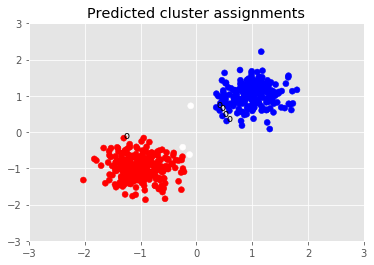

In [28]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.text(x_train[largest_five_wapdis[0]][0],x_train[largest_five_wapdis[0]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[1]][0],x_train[largest_five_wapdis[1]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[2]][0],x_train[largest_five_wapdis[2]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[3]][0],x_train[largest_five_wapdis[3]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[4]][0],x_train[largest_five_wapdis[4]][1] , "o", fontsize=10)
plt.show()

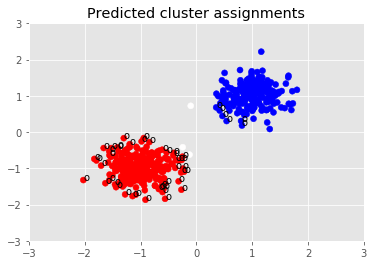

In [29]:
num_top_wapdis = 50
largest_wapdis = wapdi_values.argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=10)
plt.show()

In [2]:
import tensorflow as tf

In [26]:
a_0 = tf.expand_dims(tf.constant([ [1, 1], [2, 2], [3, 3] ], dtype='float32'), 1)
w_0 = tf.constant([ [0,0], [0,0], [0,0], [0,0] ],dtype = 'float32')
x = tf.constant([[1, 220, 55], [4, 3, -1]])
x_pseudo_max = tf.constant([[220],[4]])
x_max = tf.expand_dims(tf.reduce_max(x, reduction_indices=[1]), axis=1)
with tf.Session() as sess2:
    print(sess2.run(tf.reduce_sum(a_0)))
    print(sess2.run(tf.add(a_0,w_0)))
    print (sess2.run(tf.add(x, -x_max)))
    #print(tf.reduce_mean(tf.matmul(a_0, w_0), 0).eval())
    #print(sess.run(tf.reduce_sum(tf.log(tf.reduce_mean(tf.matmul(a_0, w_0), 0)))))

12.0
[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[2. 2.]
  [2. 2.]
  [2. 2.]
  [2. 2.]]

 [[3. 3.]
  [3. 3.]
  [3. 3.]
  [3. 3.]]]
[[-219    0 -165]
 [   0   -1   -5]]
